In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from scipy.signal import butter, filtfilt
import pandas as pd

In [2]:
data = torch.load('eeg_signals_raw_with_mean_std.pth', weights_only=False)

In [3]:
print(f"Top-level type: {type(data)}")

if isinstance(data, dict):
    for k, v in data.items():
        if hasattr(v, 'shape'):
            print(f"{k}: shape = {v.shape}")
        elif isinstance(v, list):
            print(f"{k}: list with length = {len(v)}; first element type = {type(v[0])}")
            if hasattr(v[0], 'shape'):
                print(f"    First element shape = {v[0].shape}")
        else:
            print(f"{k}: type = {type(v)}")
else:
    print("Not a dict. Top-level object:", type(data))


Top-level type: <class 'dict'>
dataset: list with length = 11965; first element type = <class 'dict'>
labels: list with length = 40; first element type = <class 'str'>
images: list with length = 1996; first element type = <class 'str'>
means: shape = torch.Size([128, 1])
stddevs: shape = torch.Size([128, 1])


In [4]:
data['dataset'][0]

{'eeg': tensor([[    0,     0,     2,  ...,   -37,   -39,   -38],
         [  -12,   -11,    -8,  ...,   -26,   -30,   -33],
         [   35,    29,    21,  ...,   -17,   -12,    -9],
         ...,
         [ -830,  -826,  -838,  ...,  -935,  -956, -1028],
         [ -782,  -848,  -840,  ...,  -951,  -987,  -994],
         [-2656, -2643, -2616,  ..., -2747, -2779, -2786]], dtype=torch.int16),
 'image': 0,
 'label': 10,
 'subject': 4}

In [5]:
for i in range(len(data['dataset'])):
    data['dataset'][i]['eeg']=data['dataset'][i]['eeg'].detach().cpu().numpy()

In [6]:
pdata=pd.DataFrame(data['dataset'])
print(pdata.head(15))
print(pdata.shape)
print(data['dataset'][0]['eeg'].shape)

                                                  eeg  image  label  subject
0   [[0, 0, 2, 4, 6, 9, 11, 14, 17, 17, 16, 14, 11...      0     10        4
1   [[-24, -27, -28, -26, -23, -19, -15, -11, -7, ...      1     30        4
2   [[-26, -24, -21, -19, -16, -15, -13, -10, -8, ...      2     29        4
3   [[-16, -12, -7, -1, 3, 7, 9, 8, 6, 4, 1, -1, -...      3     10        4
4   [[-25, -21, -16, -12, -10, -10, -11, -13, -15,...      4     30        4
5   [[-21, -19, -15, -11, -6, -2, 1, 6, 9, 11, 12,...      5     25        4
6   [[-17, -18, -17, -14, -10, -6, -3, 0, 2, 6, 9,...      6     18        4
7   [[-21, -24, -26, -24, -22, -18, -15, -12, -9, ...      7     30        4
8   [[-19, -21, -22, -21, -20, -17, -14, -10, -6, ...      8      3        4
9   [[8, 4, 0, -3, -7, -9, -10, -8, -6, -4, -1, 2,...      9      8        4
10  [[-18, -19, -20, -21, -23, -23, -22, -20, -17,...     10     11        4
11  [[-5, -8, -9, -8, -6, -3, 0, 3, 7, 12, 17, 19,...     11     18        4

In [7]:
fs = 1000     
lowcut = 5     
highcut = 95    

def bandpass_filter(signal, lowcut, highcut, fs, order=5): #order controls the distortion of the filter
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal, axis=-1)

In [8]:
pdata['eeg'] = pdata['eeg'].apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))
filtered_eeg = pdata['eeg'].tolist()

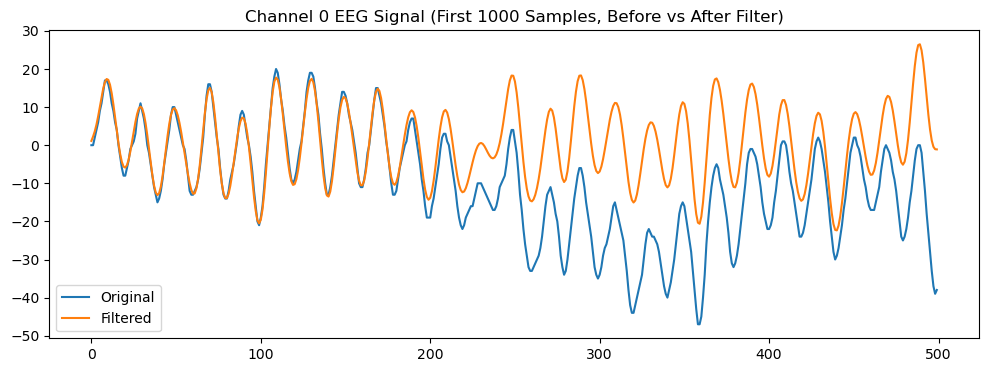

In [9]:
orig = data['dataset'][0]['eeg'][0]
filt = pdata['eeg'][0][0]
plt.figure(figsize=(12, 4))
plt.plot(orig[:1000], label='Original')
plt.plot(filt[:1000], label='Filtered')
plt.legend()
plt.title("Channel 0 EEG Signal (First 1000 Samples, Before vs After Filter)")
plt.show()

In [10]:
def normalize_channels(epoch, means=None, stddevs=None):
    """
    Args:
        epoch: np.ndarray or torch.Tensor, shape [128, T]
        means: torch.Tensor or np.ndarray, shape [128, 1] 
        stddevs: torch.Tensor or np.ndarray, shape [128, 1] 
    Returns:
        torch.Tensor: normalized epoch [128, T]
    """
    if not isinstance(epoch, torch.Tensor):
        epoch = torch.tensor(epoch.copy(), dtype=torch.float32)
    if means is None or stddevs is None:
        # Compute from this epoch if not provided
        means = epoch.mean(dim=1, keepdim=True)
        stddevs = epoch.std(dim=1, keepdim=True)
    else:
        if isinstance(means, np.ndarray):
            means = torch.tensor(means, dtype=epoch.dtype)
        if isinstance(stddevs, np.ndarray):
            stddevs = torch.tensor(stddevs, dtype=epoch.dtype)
        
    stddevs = stddevs.clone()
    stddevs[stddevs == 0] = 1e-6
    return (epoch - means) / stddevs



In [11]:
def pad_channels_to_128(epoch):
    num_channels = epoch.shape[0]
    if num_channels == 128:
        return epoch
    elif num_channels < 128:
        reps = 128 // num_channels + 1
        padded = np.tile(epoch, (reps, 1))[:128, :]
        return padded
    else:
        return epoch[:128, :]

In [12]:
for i in range(pdata.shape[0]):
    
    eeg=pdata['eeg'][i]
    # Case 1: No data at all
    if eeg is None or len(eeg) == 0:
        print("Empty EEG signal")
    
    # Case 2: All-zero or NaN
    if np.all(eeg == 0) or np.isnan(eeg).all():
        print("Invalid or empty EEG signal")


In [13]:
pdata['eeg'] = pdata['eeg'].apply(lambda x: pad_channels_to_128(x))

In [14]:
for i in range(pdata.shape[0]):
    
    eeg=pdata['eeg'][i]
    # Case 1: No data at all
    if eeg is None or len(eeg) == 0:
        print("Empty EEG signal")
    
    # Case 2: All-zero or NaN
    if np.all(eeg == 0) or np.isnan(eeg).all():
        print("Invalid or empty EEG signal")


In [15]:
pdata['eeg'] = pdata['eeg'].apply(lambda x: normalize_channels(x))

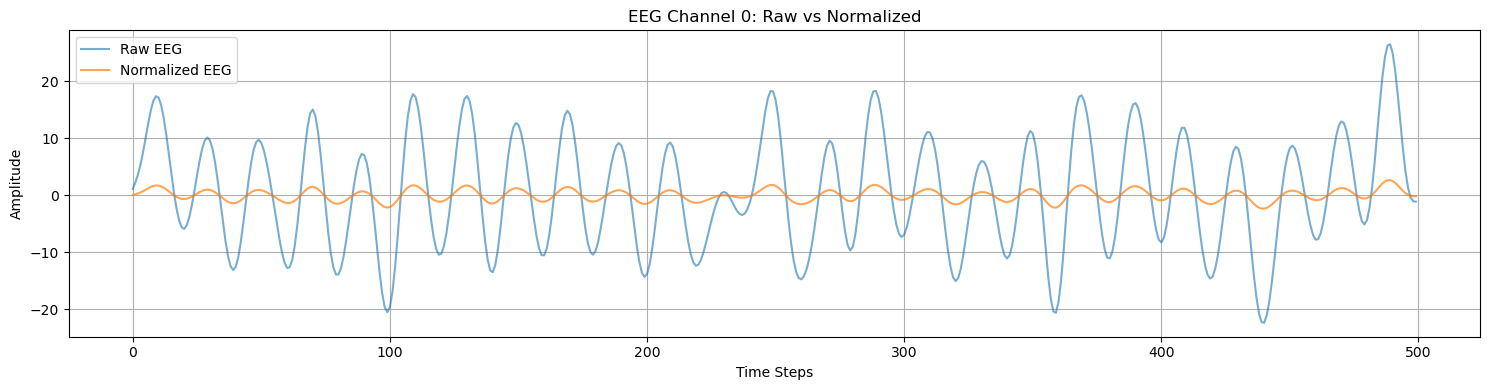

In [ ]:
# Plotting
plt.figure(figsize=(15, 4))
plt.plot(filtered_eeg[0][0], label='Raw EEG', alpha=0.6) # alpha controls transparency
plt.plot(pdata['eeg'][0][0], label='Normalized EEG', alpha=0.7)
plt.title(f'EEG Channel {0}: Raw vs Normalized')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
def tokenize_sample(eeg_sample, token_length=4):
    C, T = eeg_sample.shape

    pad_length = (token_length - (T % token_length)) % token_length
    if pad_length > 0:
        padded_data = np.pad(eeg_sample, ((0, 0), (0, pad_length)), mode='edge') 
    else:
        padded_data = eeg_sample
    
    num_tokens = padded_data.shape[1] // token_length
    tokens = padded_data.reshape(128, num_tokens, token_length)  # (128, num_tokens, 4)
    tokens = np.transpose(tokens, (1, 0, 2))  # (num_tokens, 128, 4)
    
    return tokens

In [18]:
processed_data = pd.DataFrame(pdata['eeg'].apply(lambda x : tokenize_sample(x)))

In [19]:
pdata['eeg'][0].shape

torch.Size([128, 500])

In [20]:
projection = nn.Linear(128 * 4, 1024)  

def embed(tokens):
    all_embeddings = []
    tokens = torch.tensor(tokens, dtype=torch.float32)
    flattened = tokens.reshape(-1, 128 * 4)  # (num_tokens, 512)
    embeddings = projection(flattened)
    all_embeddings.append(embeddings)
    return all_embeddings

In [21]:
processed_data['embeddings'] = processed_data['eeg'].apply(lambda x : embed(x))

C:\Users\Sahaj Bindal\AppData\Local\Temp\ipykernel_26884\1979698898.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokens = torch.tensor(tokens, dtype=torch.float32)


In [22]:
processed_data['embeddings'][0][0].shape

torch.Size([125, 1024])

In [23]:
def compute_fft(eeg_epoch, fs=1000):
    """
    Args:
        eeg_epoch (Tensor or ndarray): EEG data [128, T]
        fs (int): Sampling frequency
    """
    if isinstance(eeg_epoch, torch.Tensor):
        eeg_np = eeg_epoch.numpy()
    else:
        eeg_np = eeg_epoch

    n = eeg_np.shape[1]
    fft_vals = np.fft.rfft(eeg_np, axis=1)
    fft_mag = np.abs(fft_vals) / n
    freqs = np.fft.rfftfreq(n, d=1/fs)

    return freqs, fft_mag    

In [24]:
def plot_fft_spectrum(freqs, fft_magnitude, channel=0):
    plt.figure(figsize=(10, 4))
    plt.plot(freqs, fft_magnitude[channel])
    plt.title(f'FFT Magnitude Spectrum - Channel {channel}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xlim(0, 140)  
    plt.grid(True)
    plt.show()

In [25]:
def plot_spectrogram(eeg_epoch, channel=0, fs=1000, nperseg=256, noverlap=128):  
    """
    * mainly using STFT
    * overlap brings smoothness
    * frequency resolution of about 4Hz is needed for EEG data to distinguish between alpha, beta, and gamma waves

    Args:
        nperseg (int): Length of each FFT window
        noverlap (int): Number of overlapping samples per window
    """
    signal = eeg_epoch[channel].numpy()

    plt.figure(figsize=(10, 6))
    plt.specgram(signal, NFFT=nperseg, Fs=fs, noverlap=noverlap, scale='dB', cmap='viridis')
    # NFFT is no. of points in each segment for frequency resolution

    plt.title(f'Spectrogram - Channel {channel}')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Power (dB)')
    plt.ylim(0, 140)
    plt.tight_layout()
    plt.show()


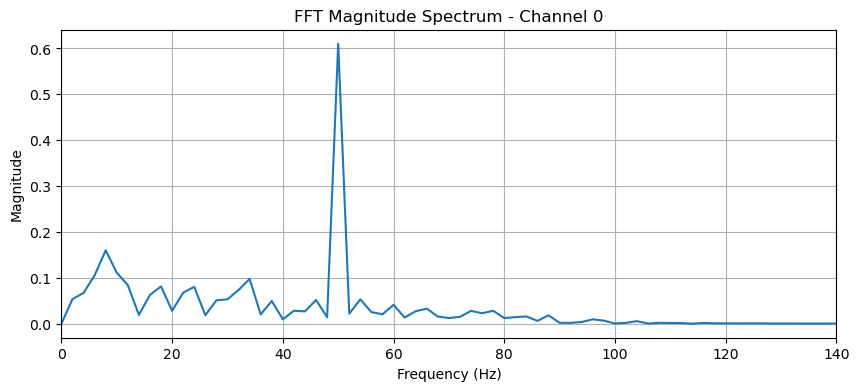

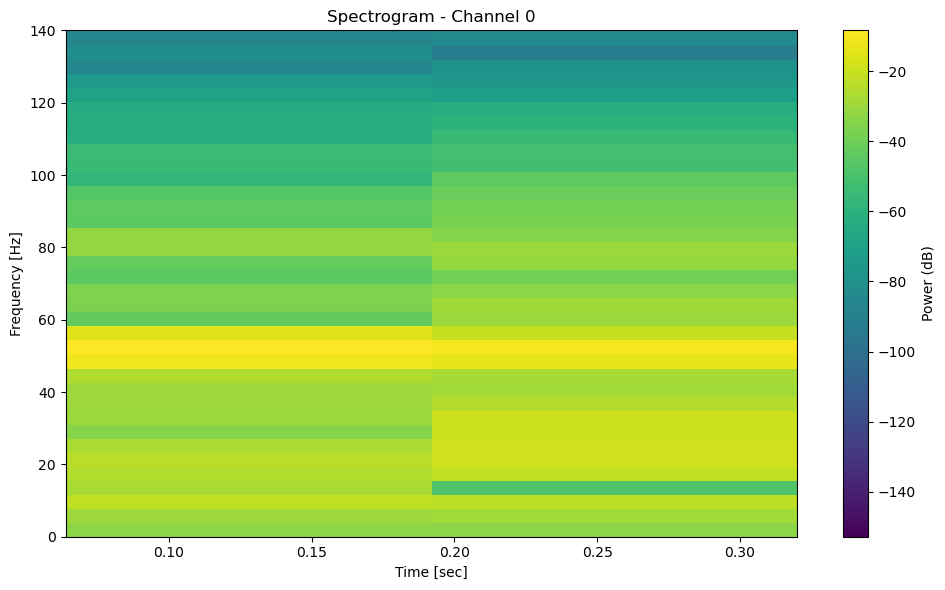

In [26]:
example_epoch = pdata['eeg'][0]  # shape [128, T]
freqs, fft_mag = compute_fft(example_epoch)
plot_fft_spectrum(freqs, fft_mag, channel=0)
plot_spectrogram(example_epoch, channel=0)